## Data preprocess using Natural Language Toolkit, Logistic Regression

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# module provides regular expression matching operations (https://www.w3schools.com/python/python_regex.asp)
import re

# module implements binary protocols for serializing and de-serializing a Python object
import pickle

# natural language toolkit (https://realpython.com/nltk-nlp-python/)
# (https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/)
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

# filter common words
from nltk.corpus import stopwords
# split text into words
from nltk.tokenize import word_tokenize
# nltk.download('averaged_perceptron_tagger')

# reduce words to their root by cutting common suffixes and prefixes (ex. goes -> goe)
from nltk.stem.porter import PorterStemmer
# reduce words to their root by transformin to initial form with ectual meaning (ex. goes -> go )
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('omw-1.4')

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# # Silent warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
raw_df = pd.read_csv('../data/cleaned_news.csv', index_col=False)
raw_df.head()

,text,true
0,donald trump just couldn t wish all americans ...,0
1,house intelligence committee chairman devin nu...,0
2,on friday it was revealed that former milwauke...,0
3,on christmas day donald trump announced that h...,0
4,pope francis used his annual christmas day mes...,0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38589 entries, 0 to 38588
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    38589 non-null  object
 1   true    38589 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 603.1+ KB


In [4]:
print(raw_df.shape)
raw_df.isnull().sum()

(38589, 2)


text    0
true    0
dtype: int64

### Clean text of stopwords (common used (english) words) and punctuation, fold to lowercase, lemmatize to stem

In [5]:
# simplifies position of speech tags

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None


def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
 
    # tokenize text into words, clean of punctuation and stopwords
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]  

    # tokenize text including position of speech
    text = nltk.pos_tag(text)   
    text = list(map(lambda x: (x[0], pos_tagger(x[1])), text))

    # lemmatize words with respect to position of speech
    text_ = []    
    for word, tag in text:
        if tag is None:
            text_.append(word)
        else:
            text_.append(lemma.lemmatize(word, tag))
    text = ' '.join(text_) 
    return text

In [6]:
# # Test
# # expected result: 'indonesia buy sukhoi fighter jet go dog reveal'
# test = "indonesia will buy sukhoi fighters jets  goes dogs revealed "
# test = preprocess_text(test)
# test

### Preprocess text column

In [7]:
raw_df['text'] = raw_df['text'].apply(preprocess_text)
raw_df.head()

,text,true
0,donald trump wish american happy new year leav...,0
1,house intelligence committee chairman devin nu...,0
2,friday reveal former milwaukee sheriff david c...,0
3,christmas day donald trump announce would back...,0
4,pope francis use annual christmas day message ...,0


### Plot how balanced dataset is

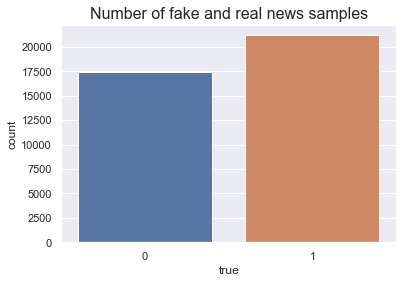

In [8]:
sns.countplot(x='true', data=raw_df)
plt.title('Number of fake and real news samples', fontdict={'fontsize':16})
plt.show()

### Separate independent variables from target

In [9]:
X = raw_df['text'].values
y = raw_df['true'].values

X.shape, y.shape

((38589,), (38589,))

## Convert text Series into matrix of TF-IDF features

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

In [10]:
vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,3))
vectorizer.fit(X)

X = vectorizer.transform(X)

In [11]:
X.shape

(38589, 5000)

In [12]:
print(X[0])

  (0, 4978)	0.03166267399127037
  (0, 4974)	0.044453586619715435
  (0, 4971)	0.26294630538671016
  (0, 4965)	0.03443377263242081
  (0, 4949)	0.04086421395548786
  (0, 4938)	0.028237638283939312
  (0, 4926)	0.0201750055742859
  (0, 4925)	0.029259532165464258
  (0, 4921)	0.03916053464281713
  (0, 4910)	0.20034490661333118
  (0, 4818)	0.03976969910887745
  (0, 4799)	0.02262201504154944
  (0, 4721)	0.020247158342724596
  (0, 4600)	0.12055484475426446
  (0, 4575)	0.044482368871119435
  (0, 4559)	0.08084273951844907
  (0, 4550)	0.04876391961677266
  (0, 4526)	0.11569602960849201
  (0, 4370)	0.029721551589924976
  (0, 4347)	0.051836810696448014
  (0, 4312)	0.02359199062239268
  (0, 4248)	0.05621276563071365
  (0, 4201)	0.0601094484706241
  (0, 4174)	0.04654076250753887
  (0, 4133)	0.036605529550465574
  :	:
  (0, 1151)	0.0344158530316766
  (0, 1139)	0.038157269660807
  (0, 1031)	0.4562398491613125
  (0, 1007)	0.04915185617492768
  (0, 928)	0.03723790021549744
  (0, 877)	0.027462477855519717
 

### Save dataframe (matrix and target) into .csv

In [13]:
with open('preprocessed_X.pkl', 'wb') as f:
    pickle.dump(X, f)
    
with open('preprocessed_y.pkl', 'wb') as f:
    pickle.dump(y, f)

In [14]:
with open('preprocessed_X.pkl', 'rb') as f:
    X = pickle.load(f)
    
with open('preprocessed_y.pkl', 'rb') as f:
    y = pickle.load(f)

### Split training data into train and test sets

In [15]:
# Split data into train and test sets in ratio 75%/25% (pseudo randomized random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((28941, 5000), (28941,), (9648, 5000), (9648,))

### LogisticRegression default parameters

In [16]:
# __init__, fit LogisticRegression
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
logistic_model.get_params(deep=True)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Print classification report for default parameters logistic model

In [17]:
print(classification_report(y_test, logistic_model.predict(X_test), target_names = ['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98      4345
        Real       0.98      0.99      0.98      5303

    accuracy                           0.98      9648
   macro avg       0.98      0.98      0.98      9648
weighted avg       0.98      0.98      0.98      9648



### Plot confusion matrix for logistic regression with tuned hyperparameters

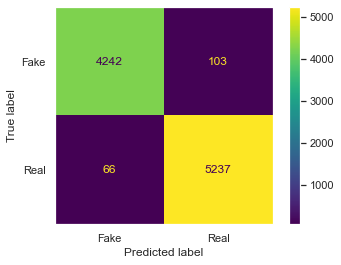

In [18]:
plot_confusion_matrix(logistic_model, X_test, y_test, values_format='d', display_labels=['Fake', 'Real'])
plt.grid(False)

### GridSearchCV hyperparameters tuned Logistic model

**GridSearchCV** (auto search optimal hyperparameters) loops through every combination of the values in the grid,
 evaluating the performance using cross-validation to find the optimum combination of values

**estimator**: Model instance
<br>**param_grid**: Dictionary object that holds the hyperparameters we wish to experiment with
<br>**scoring**: Strategy to evaluate the performance of the cross-validated model on the test set
<br>**n_jobs**: Number of processes you wish to run in parallel for this task if it is -1 it will use all available processors
<br>**cv**: The total number of cross-validations we perform for each hyperparameter
<br>**verbose**: Detailed print out of your fit of the data
<br>**error_score**: Value to assign to the score if an error occurs in estimator fitting
<br>https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=grid%20search#sklearn.model_selection.GridSearchCV

**LogisticRegression** hyperparameters
<br>**penalty**: Specify the norm of the penalty (regularisation technique to prevent overfitting)
<br>**C**: Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization
<br>**solver**: Algorithm to use in the optimization problem
<br>**max_iter**: Maximum number of iterations taken for the solvers to converge

In [19]:
lm_params_grid = {'C': [0.1],
                  'solver': ['newton-cg','lbfgs','liblinear','sag','saga'],
                  'max_iter': [100, 250, 500, 1000],                  
                 }

lm_grid = GridSearchCV(estimator=LogisticRegression(random_state=42),
                       param_grid=lm_params_grid,
                       n_jobs=-1,   
                       verbose=0,
                       cv = 3
                      )

lm_grid.fit(X_train, y_train)
lm_grid.best_params_

{'C': 0.1, 'max_iter': 100, 'solver': 'newton-cg'}

In [20]:
lm_param_tuned = LogisticRegression().set_params(**lm_grid.best_params_)
lm_param_tuned.fit(X_train, y_train)

LogisticRegression(C=0.1, solver='newton-cg')

### Print classification report for parameters tuned logistic model

In [21]:
print(classification_report(y_test, lm_param_tuned.predict(X_test), target_names = ['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.98      0.95      0.96      4345
        Real       0.96      0.98      0.97      5303

    accuracy                           0.97      9648
   macro avg       0.97      0.97      0.97      9648
weighted avg       0.97      0.97      0.97      9648



### Plot confusion matrix for logistic regression with tuned hyperparameters

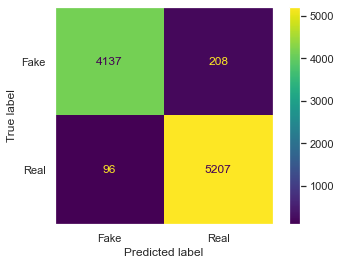

In [22]:
plot_confusion_matrix(lm_param_tuned, X_test, y_test, values_format='d', display_labels=['Fake', 'Real'])
plt.grid(False)

### Save vectorizer

In [23]:
with open('tfidfVectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

### Save trained model

In [24]:
with open('LogReg_tuned.pkl', 'wb') as f:
    pickle.dump(lm_param_tuned, f)

### Plot Receiver operating characteristic (ROC) curve

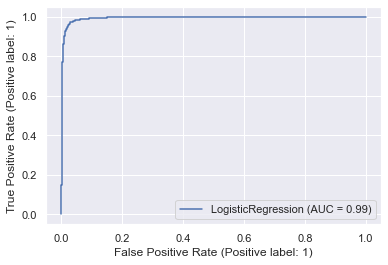

In [25]:
metrics.plot_roc_curve(lm_param_tuned, X_test, y_test) 
plt.show()